In [1]:
import os
import numpy as np
import math
import cv2
from collections import OrderedDict

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (80,60)

data_path = '/home/strider/Code/robotron/training/data/'

In [2]:
classes = []
for line in open(data_path + 'classes.txt'):
    classes.append(line.strip())
    
print(classes)

['Player', 'Civilian', 'Grunt', 'Hulk', 'Sphereoid', 'Enforcer', 'Brain', 'Tank', 'Quark', 'Electrode', 'Enforcer Bullet', 'Converted Civilian', 'Brain Bullet']


In [3]:
# From https://github.com/activatedgeek/LeNet-5/blob/b9d7f39a752d23a7de60ea6d679812c401fab57e/lenet.py#L5

class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 13)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output
    
model = LeNet5().cuda()
model.load_state_dict(torch.load(data_path + "saved_model.pt"))
model.eval()

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=84, out_features=13, bias=True)
    (sig7): LogSoftmax()
  )
)

In [4]:
# We need to prepare each image the same way for the nn
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
def crop(image, coords):
    (left, top, right, bottom) = coords
    return image[left:right, top:bottom]

def resize(image):
    return cv2.resize(image, (32, 32))
    
def prepare_image(image):
    image = to_gray(image)
    image = resize(image)
    return image

def prepare_screen(image):
    image = crop(image, (116, 309, 608, 974))
    image = to_gray(image)
    return image

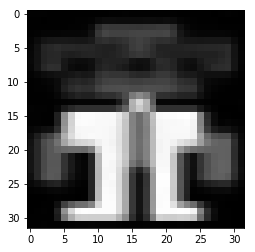

In [5]:
img = cv2.imread(data_path+"sprites/Player/187f7e187edf1c24.jpg")
img = prepare_image(img)
plt.imshow(img, cmap='gray')

In [12]:
with torch.no_grad():
    X = torch.tensor([img.reshape(1, 32, 32)], dtype=torch.float).cuda()
    outputs = model(X)
    print(outputs)
    _, predicted = torch.max(outputs, 1)
    print(predicted)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(1)))

tensor([[  0.0000, -30.7851, -37.7909, -42.0045, -40.2744, -52.4236, -40.5037,
         -50.1200, -52.1502, -45.7229, -47.7640, -58.8580, -64.5388]],
       device='cuda:0')
tensor([0], device='cuda:0')
Predicted:  Player


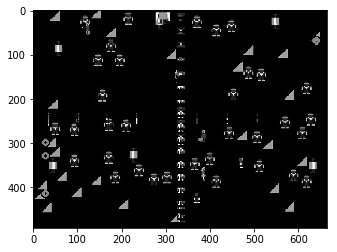

In [7]:
screen = prepare_screen(cv2.imread(data_path+"screens/1578983471.627474.jpg"))
plt.imshow(screen, cmap='gray')

In [10]:
tagged = screen.copy()
_, thresh = cv2.threshold(screen, 16, 255, 0)
blur = cv2.GaussianBlur(thresh, (3, 3), 0)
contours, _ = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

for contour in enumerate(contours):
    rect = cv2.boundingRect(contour[1])
    (x, y, w, h) = rect
    if h > 7 and w > 7:
            cv2.rectangle(tagged, (x, y), (x+w, y+h), (255, 255, 255), 2)
            sprite = crop(thresh, (x, y, w, h))

150


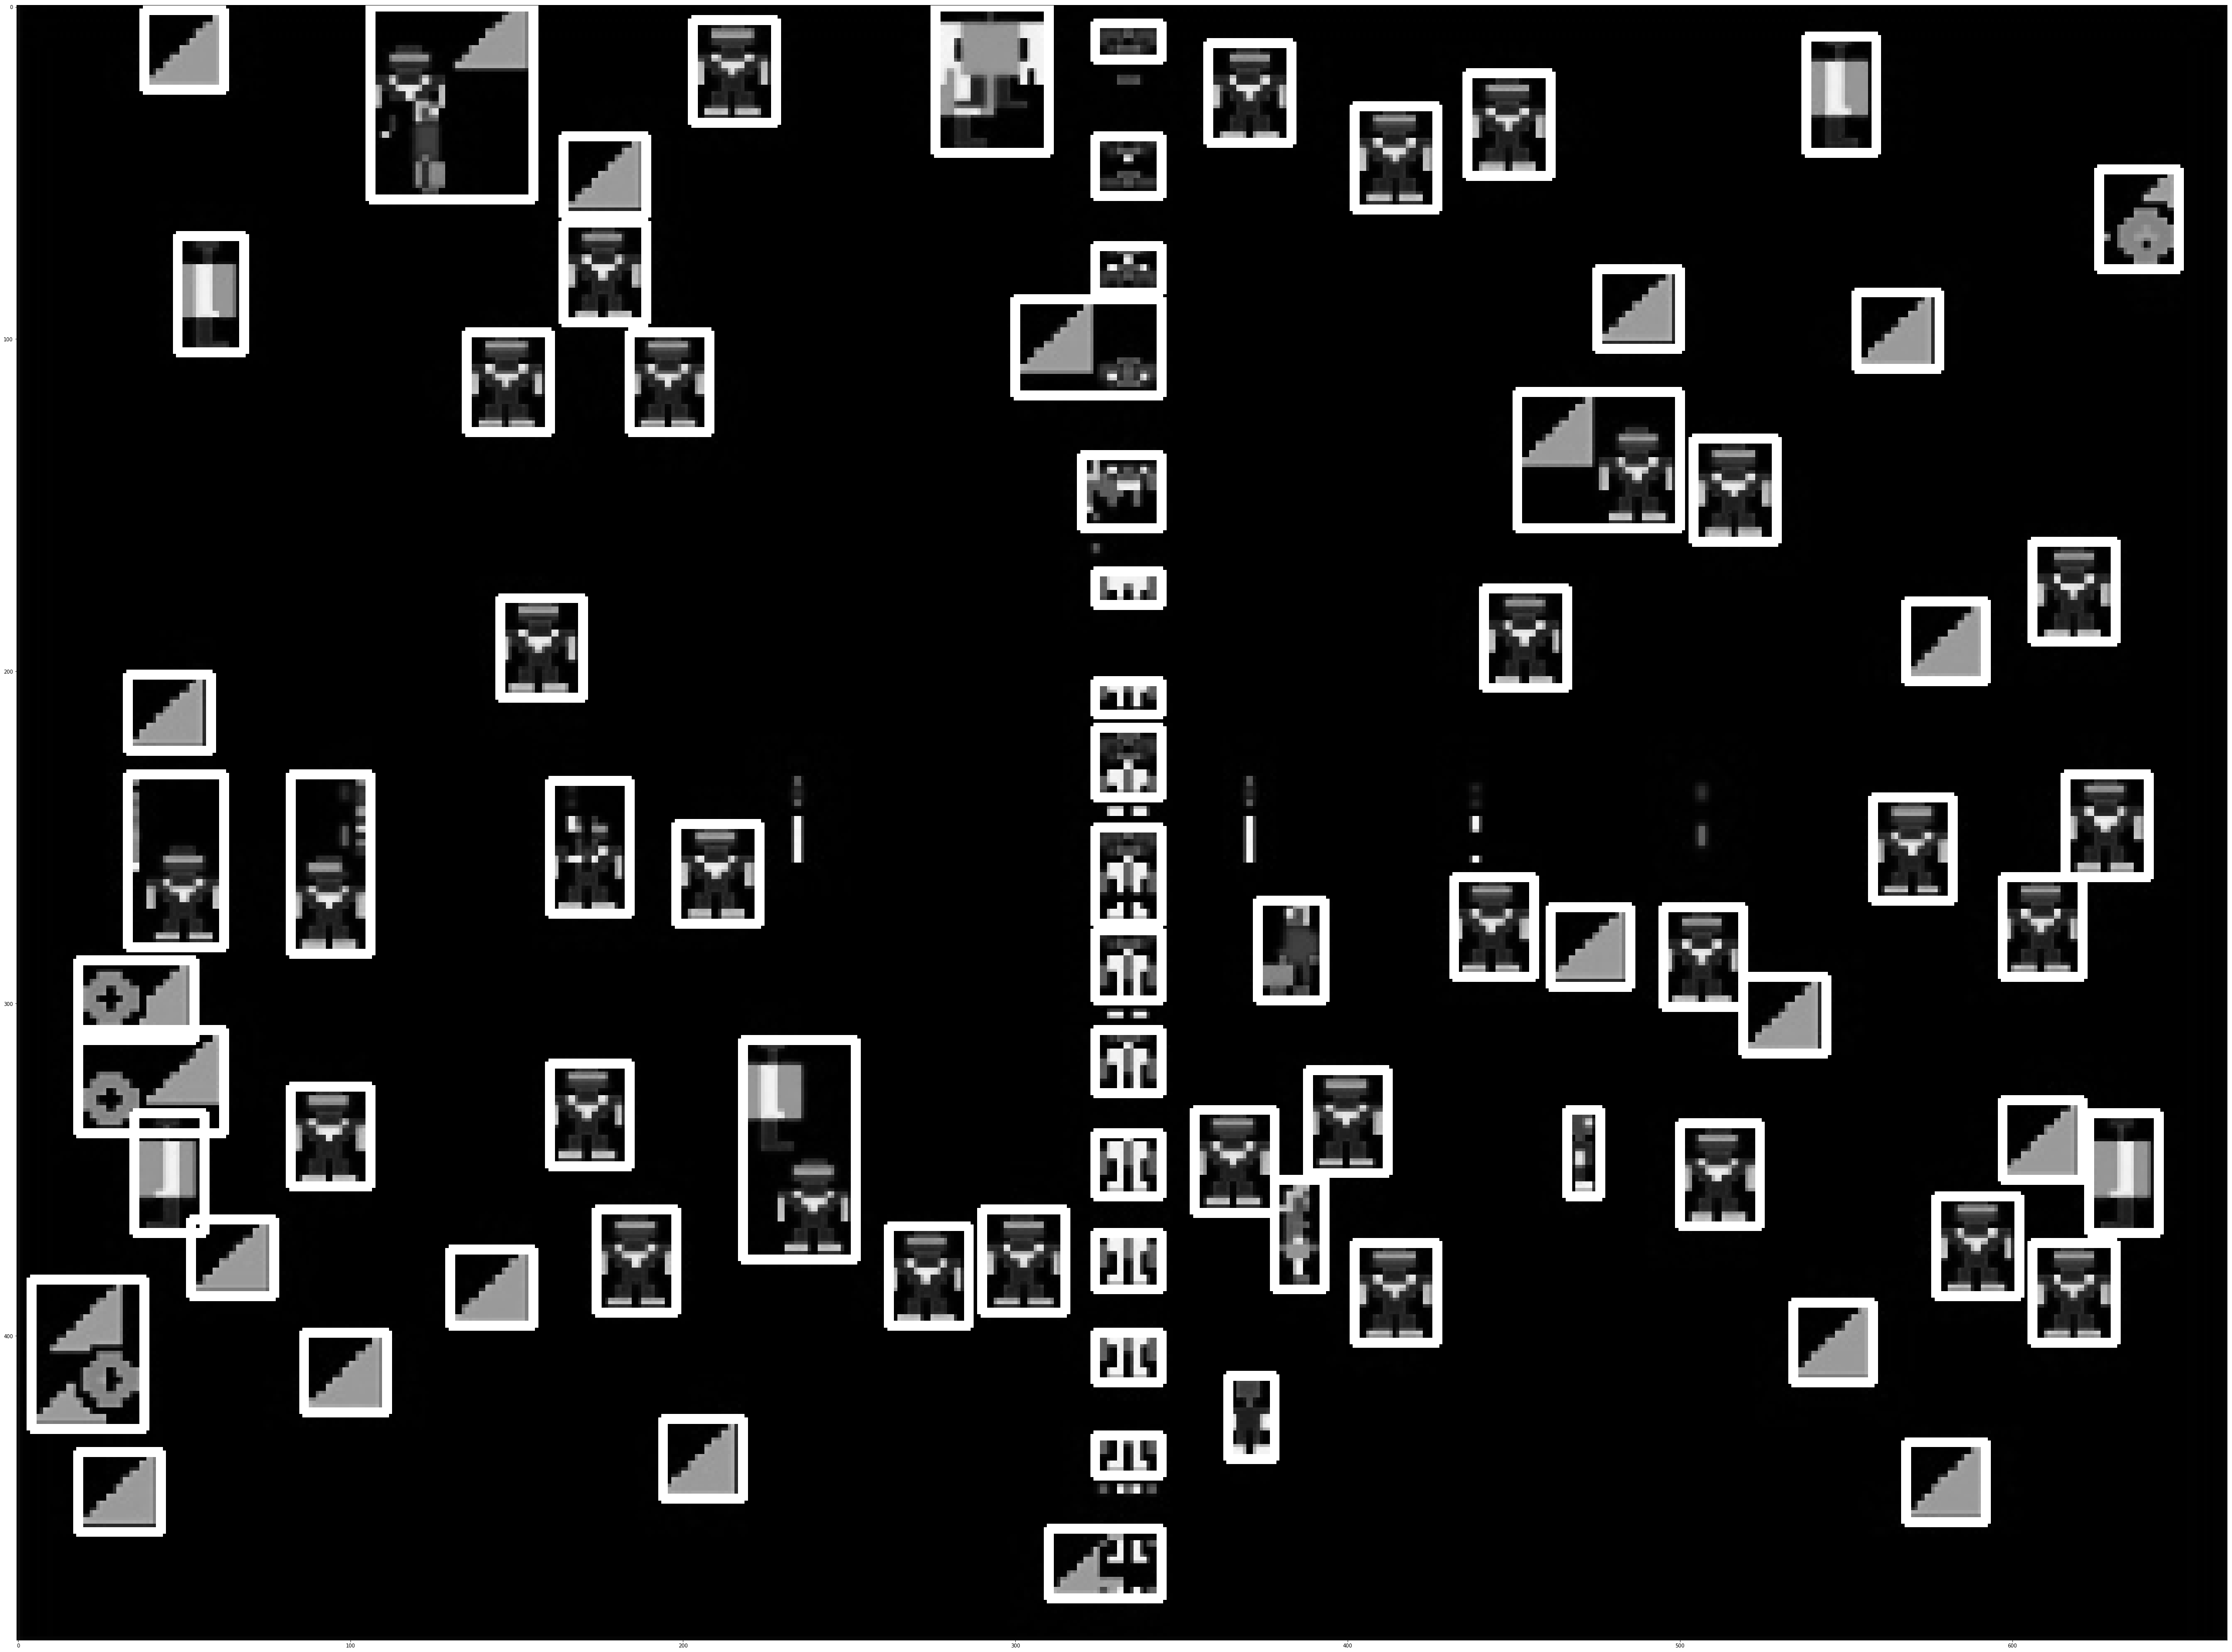

In [11]:
plt.rcParams["figure.figsize"] = (80,60)

plt.imshow(tagged, cmap='gray')